In [1]:
# want to store this notebook in the notebooks folder, but want to keep non-relative imports
import os
os.chdir("..")

In [2]:
import sys
from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference, gene_inference.utils
from gene_inference.models import lr, mlp, decision_tree
from gene_inference.infer_genes import infer_gene, infer_all_genes, sample_neighbors
from data.graph import Graph

/u/weissmar/venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import sys
sys.executable


'/u/weissmar/venv/bin/python'

In [4]:
tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [5]:
class Object(object):
    pass
opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue

In [6]:
graph = Graph()
graph.load_graph("/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5")
#graph.intersection_with(tcgatissue)

In [7]:
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)


In [8]:
# This reduces the number of genes that we're testing. 
# Remove the iloc to run the full dataset. Should take ~1.5 hours.

df = tcgatissue.df
lr_df = infer_all_genes(lr, df, train_size=100, test_size=300, trials=2, penalty=True).reset_index(drop=True)
mlp_df = infer_all_genes(mlp, df, train_size=100, test_size=300, trials=3, penalty=False).reset_index(drop=True)
dt_df = infer_all_genes(decision_tree, df, train_size=100, test_size=300, trials=3, penalty=False).reset_index(drop=True)


AttributeError: 'DataFrame' object has no attribute 'df'

In [9]:
# Predict a gene from a growing number of samples
gene = "RPL5"
max_train_size = 100
full_results = pd.DataFrame([])
first_degree_results = pd.DataFrame([])
first_degree = set(g.neighbors("RPL5"))
first_degree.add("RPL5")

for train_size in range(10, max_train_size, 10):
    print train_size
    
    full_results = full_results.append(infer_gene(lr, tcgatissue.df, "RPL5", train_size, test_size=200, trials=10, penalty=True)).reset_index(drop=True)
    full_results.loc[full_results.index[-1], 'samples'] = train_size
    first_degree_results = first_degree_results.append(infer_gene(lr, tcgatissue.df.loc[:, first_degree], "RPL5", train_size, test_size=200, trials=10, penalty=True)).reset_index(drop=True)
    first_degree_results.loc[first_degree_results.index[-1], 'samples'] = train_size

10
20
30
40
50
60
70
80
90


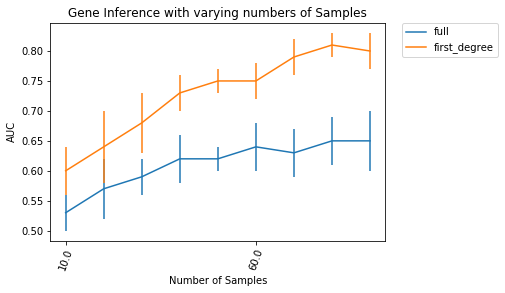

In [10]:
# results of adding Samples
plt.figure()

line1 = plt.errorbar(full_results.index, full_results['auc'], xerr=0, yerr=full_results['std'])
line2 = plt.errorbar(first_degree_results.index, first_degree_results['auc'], xerr=0, yerr=first_degree_results['std'])

width = 0.2
plt.xticks(list(full_results.iloc[::5, :].index), full_results.iloc[::5, :]['samples'], rotation=70)
plt.title("Gene Inference with varying numbers of Samples")
plt.ylabel("AUC")
plt.xlabel("Number of Samples")
plt.legend((line1[0], line2[0]), ('full', 'first_degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [11]:
# Predict a gene from a growing number of Nodes
results = pd.DataFrame([])
gene = "RPL5"
num_samples = 100
max_genes = 100

for num_genes in range(10, max_genes, 10):
    neighbors = sample_neighbors(g, "RPL5", num_genes)
    temp_df = tcgatissue.df.loc[:, neighbors]
    full_row = infer_gene(lr, temp_df, "RPL5", train_size=200, test_size=200, trials=10, penalty=False)
    results = results.append(full_row).reset_index(drop=True)
    results.loc[results.index[-1], 'num_genes'] = num_genes


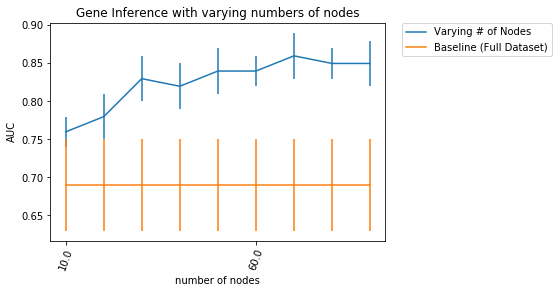

In [12]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(results.index, results['auc'], xerr=0, yerr=results['std'])
line2 = plt.errorbar(results.index, list(repeat(0.69, len(full_results))), xerr=0, yerr=list(repeat(0.06, len(full_results))))

width = 0.2
plt.xticks(list(results.iloc[::5, :].index), results.iloc[::5, :]['num_genes'], rotation=70)
plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.legend((line1[0], line2[0]), ('Varying # of Nodes', "Baseline (Full Dataset)"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [13]:
results

,auc,gene_name,num_genes,std
0,0.76,RPL5,10.0,0.02
1,0.78,RPL5,20.0,0.03
2,0.83,RPL5,30.0,0.03
3,0.82,RPL5,40.0,0.03
4,0.84,RPL5,50.0,0.03
5,0.84,RPL5,60.0,0.02
6,0.86,RPL5,70.0,0.03
7,0.85,RPL5,80.0,0.02
8,0.85,RPL5,90.0,0.03


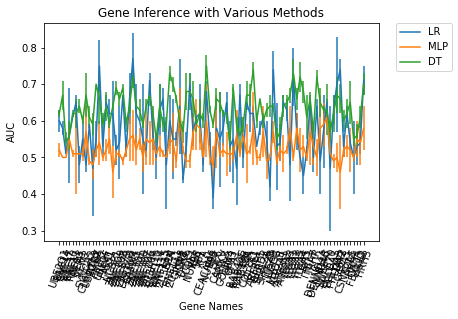

In [15]:
# AUC
plt.figure()

line1 = plt.errorbar(lr_df.index, lr_df['auc'], xerr=0, yerr=lr_df['std'])
line2 = plt.errorbar(mlp_df.index, mlp_df['auc'], xerr=0, yerr=mlp_df['std'])
line3 = plt.errorbar(dt_df.index, dt_df['auc'], xerr=0, yerr=dt_df['std'])

width = 0.2
plt.xticks(lr_df.index, lr_df['gene_name'], rotation=70)
plt.title("Gene Inference with Various Methods")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.legend((line1[0], line2[0], line3[0]), ('LR', 'MLP', 'DT'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [ ]:
# LR 
plt.figure()
line1 = plt.errorbar(lr_df.index, lr_df['auc'], xerr=0, yerr=lr_df['std'])
line2 = plt.errorbar(lr_df.index, lr_df['first_degree_auc'], xerr=0, yerr=lr_df['first_degree_std'])
line3 = plt.errorbar(lr_df.index, lr_df['second_degree_auc'], xerr=0, yerr=lr_df['second_degree_std'])

width = 0.2
plt.xticks(lr_df.index, lr_df['gene_name'], rotation=70)
plt.title("Gene Inference with LR")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.legend((line1[0], line2[0], line3[0]), ('Full Dataset', 'First Degree', 'Second Degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

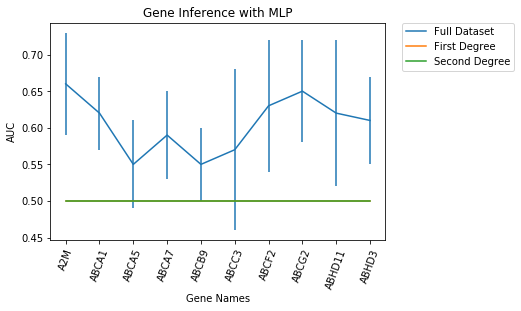

In [24]:
#mlp
plt.figure()
line1 = plt.errorbar(mlp_df.index, mlp_df['auc'], xerr=0, yerr=mlp_df['std'])
line2 = plt.errorbar(mlp_df.index, mlp_df['first_degree_auc'], xerr=0, yerr=mlp_df['first_degree_std'])
line3 = plt.errorbar(mlp_df.index, mlp_df['second_degree_auc'], xerr=0, yerr=mlp_df['second_degree_std'])

width = 0.2
plt.xticks(mlp_df.index, mlp_df['gene_name'], rotation=70)
plt.title("Gene Inference with MLP")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.legend((line1[0], line2[0], line3[0]), ('Full Dataset', 'First Degree', 'Second Degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

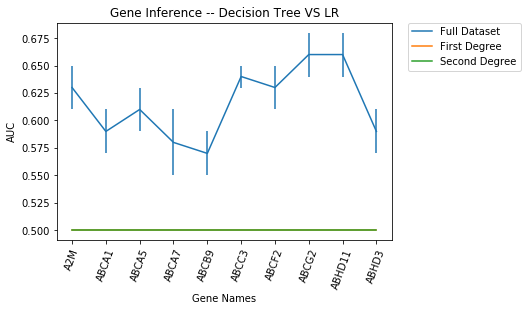

In [26]:
# Decision Tree
plt.figure()

line1 = plt.errorbar(dt_df.index, dt_df['auc'], xerr=0, yerr=dt_df['std'])
line2 = plt.errorbar(dt_df.index, dt_df['first_degree_auc'], xerr=0, yerr=dt_df['first_degree_std'])
line3 = plt.errorbar(dt_df.index, dt_df['second_degree_auc'], xerr=0, yerr=dt_df['second_degree_std'])

width = 0.2
plt.xticks(dt_df.index, dt_df['gene_name'], rotation=70)
plt.title("Gene Inference -- Decision Tree VS LR")
plt.ylabel("AUC")
plt.xlabel("Gene Names")

# Legend
plt.legend((line1[0], line2[0], line3[0]), ('Full Dataset', 'First Degree', 'Second Degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)


In [ ]:
# Graphical Character example

In [455]:
# 1st degree
first_degree_neighbors = g.neighbors("RPL5")
first_degree_neighbor_subgraph = g.subgraph(first_degree_neighbors)

'num nodes:29'

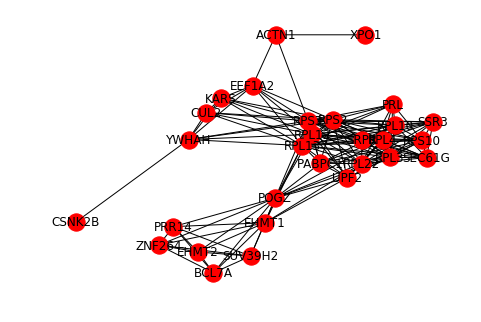

In [456]:
pos = nx.spring_layout(first_degree_neighbor_subgraph, k=1.45,iterations=100)
nx.draw(first_degree_neighbor_subgraph, pos=pos, with_labels=True)
"num nodes:" + str(len([x for x  in g.neighbors("RPL5")]))

In [299]:
# 2nd degree
second_degree_neighborhood = []
for n in g.neighbors("RPL5"):
    second_degree_neighborhood.extend(g.neighbors(n))
second_degree_subgraph = g.subgraph(second_degree_neighborhood)

'num nodes:1147'

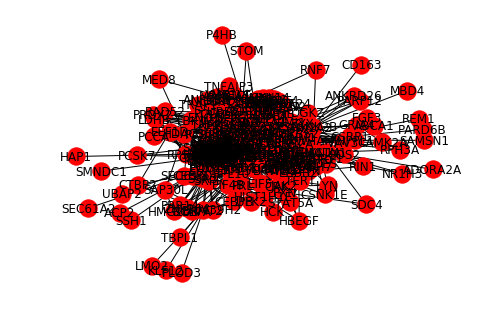

In [300]:
pos = nx.spring_layout(second_degree_subgraph, k=.25,iterations=100)
nx.draw(second_degree_subgraph, pos=pos, with_labels=True)
"num nodes:" + str(len(second_degree_neighborhood))